# Imports and read-ins

In [2]:
import pandas as pd
import numpy as np
import sys
%matplotlib notebook
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, splrep
from Time_sync_functions import smooth_DTD, model_spline_part

In [3]:
receiver_complete = pd.read_pickle('example_rec_461211.pkl')
ts = receiver_complete['Time']

# DTD and spline of receiver synctag

In [4]:
Srec_on_rec = pd.read_pickle('461211_Srec.pkl')

<IPython.core.display.Javascript object>


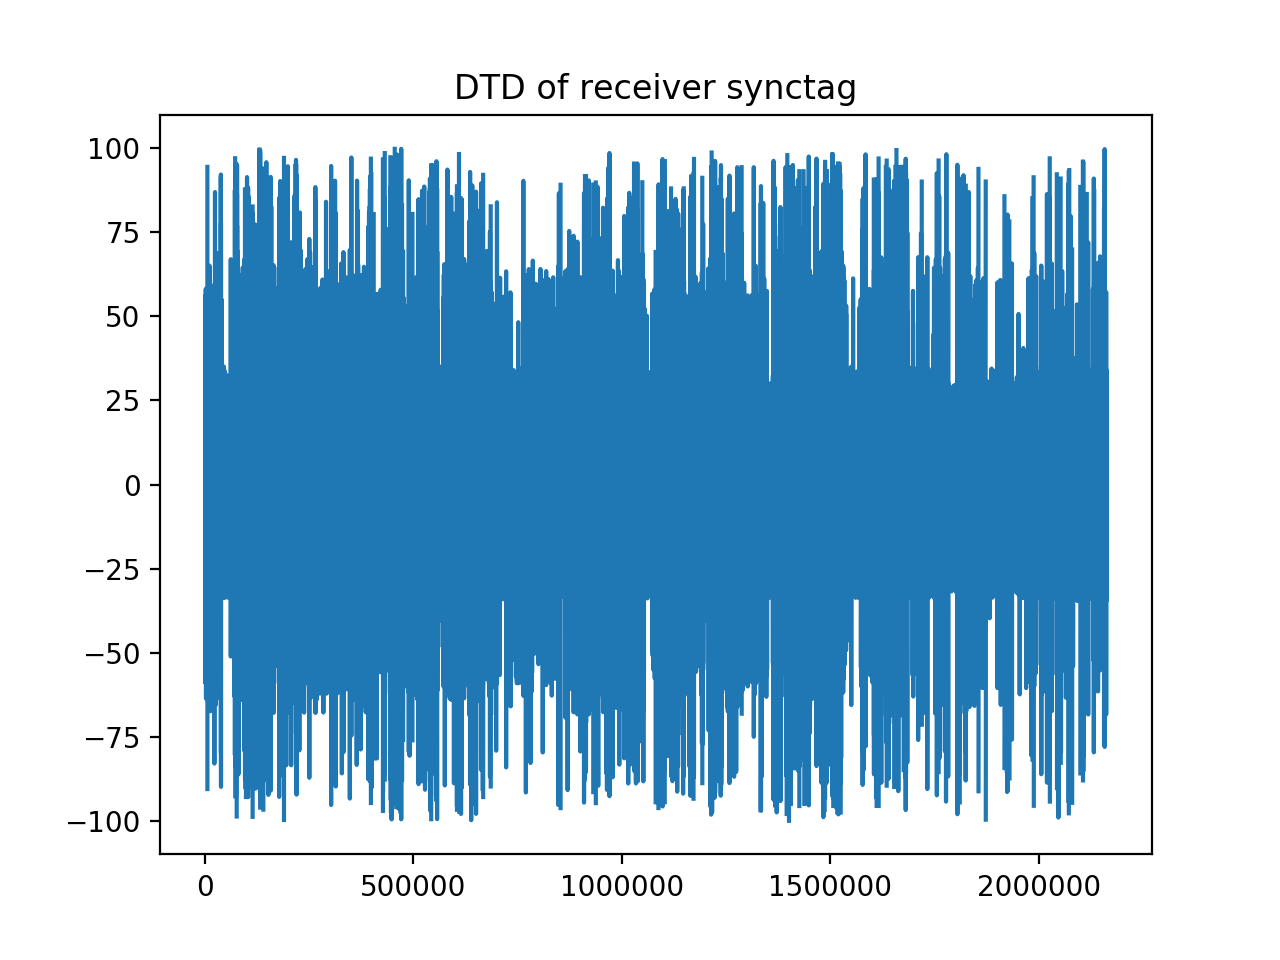

Text(0.5, 1.0, 'DTD of receiver synctag')

In [7]:
fig,ax = plt.subplots()
Srec_on_rec.DTD.plot(ax=ax)
ax.set_title('DTD of receiver synctag')


**Smoothing of DTD**   
This is needed to finally model a smooth spline, otherwise it will be jumpy!   
Play with the parameters to get the DTD smooth enough.   
e.g. in the example, if you set window_size=1 with outlier_lim=0.005,   
you will see the effect of insufficient smoothing   
Zoom in on the figure to check smoothness! (especially at jumps!)

In [6]:
Srec_on_rec = smooth_DTD(Srec_on_rec, outlier_lim=0.005, window_size=5)
# If the DTD is already smooth enough, uncomment line below and comment line above:
#Srec_on_rec['DTD_smooth'] = Srec_on_rec['DTD']

<IPython.core.display.Javascript object>


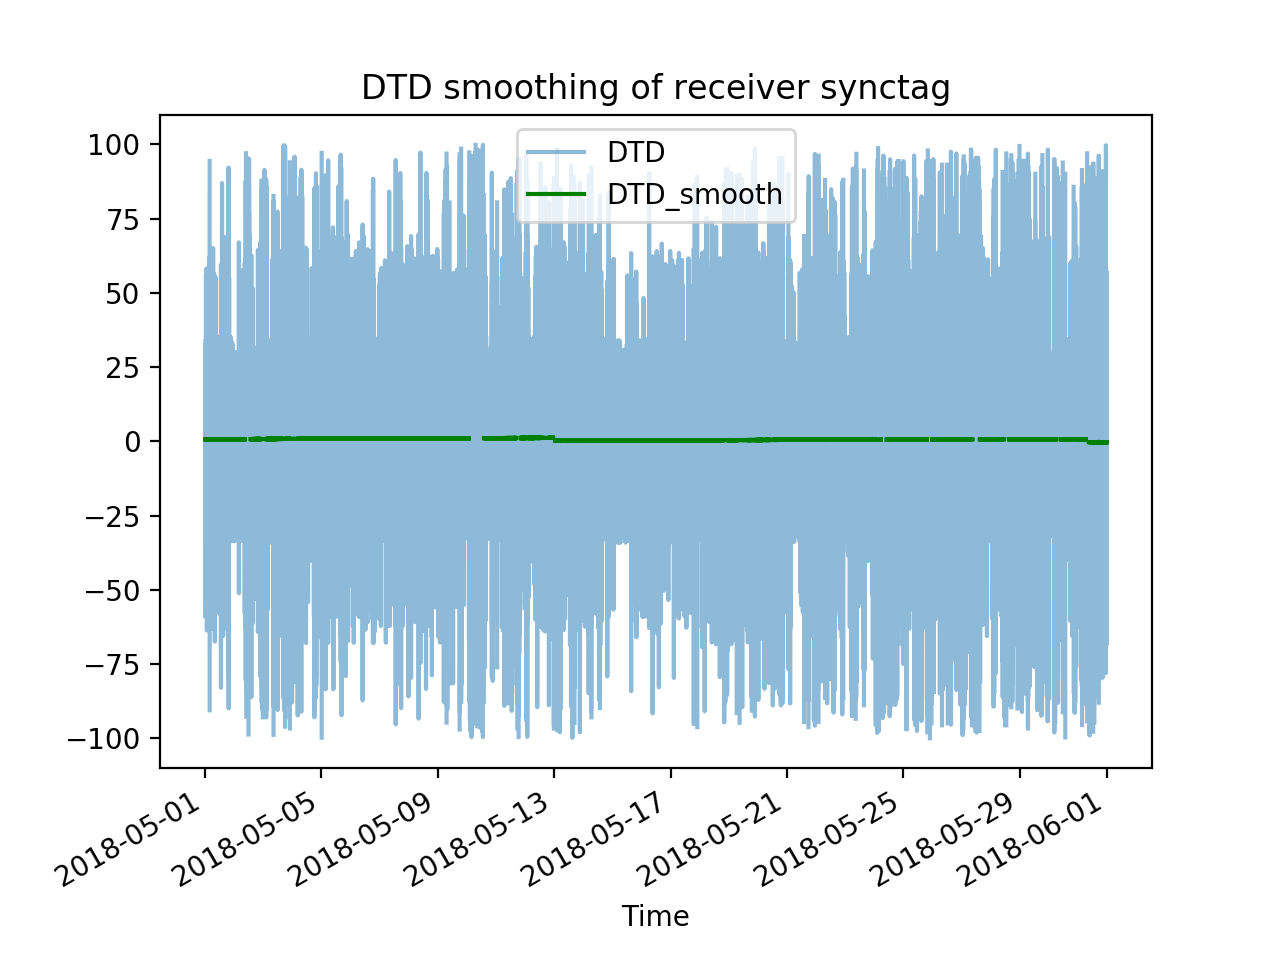

Text(0.5, 1.0, 'DTD smoothing of receiver synctag')

In [8]:
fig,ax = plt.subplots()
Srec_on_rec.plot(x='Time',y='DTD', ax=ax, alpha=0.5, label='DTD')
Srec_on_rec.plot(x='Time',y='DTD_smooth',  ax=ax, c='green', label='DTD_smooth')
ax.set_title('DTD smoothing of receiver synctag')

**Split the dataframe in groups at the jumps.**   
Jumps might occur when for instance the receiver got an internal clock shift...   
These things happen, apparently...


In [10]:
DTD_part_Srec = Srec_on_rec[['Time', 'DTD_smooth']].set_index('Time')
DTD_part_Srec = DTD_part_Srec.dropna()
gaps = DTD_part_Srec.DTD_smooth.diff().abs()>0.1
groups = gaps.cumsum()
df_grouped = DTD_part_Srec.groupby(groups)

**Model the spline of each group**

In [11]:
spline_groups = df_grouped.apply(lambda x: model_spline_part(x, ts, k=5, s=5e-4))
ys_Srec = spline_groups.reset_index()
ys_Srec.rename(columns={'spline':'spline_Srec'}, inplace=True)

Check if there is nice correspondance between spline and DTD (zoom in!!)   
If not, play with the parameters of model_spline_part or smooth_DTD


<IPython.core.display.Javascript object>


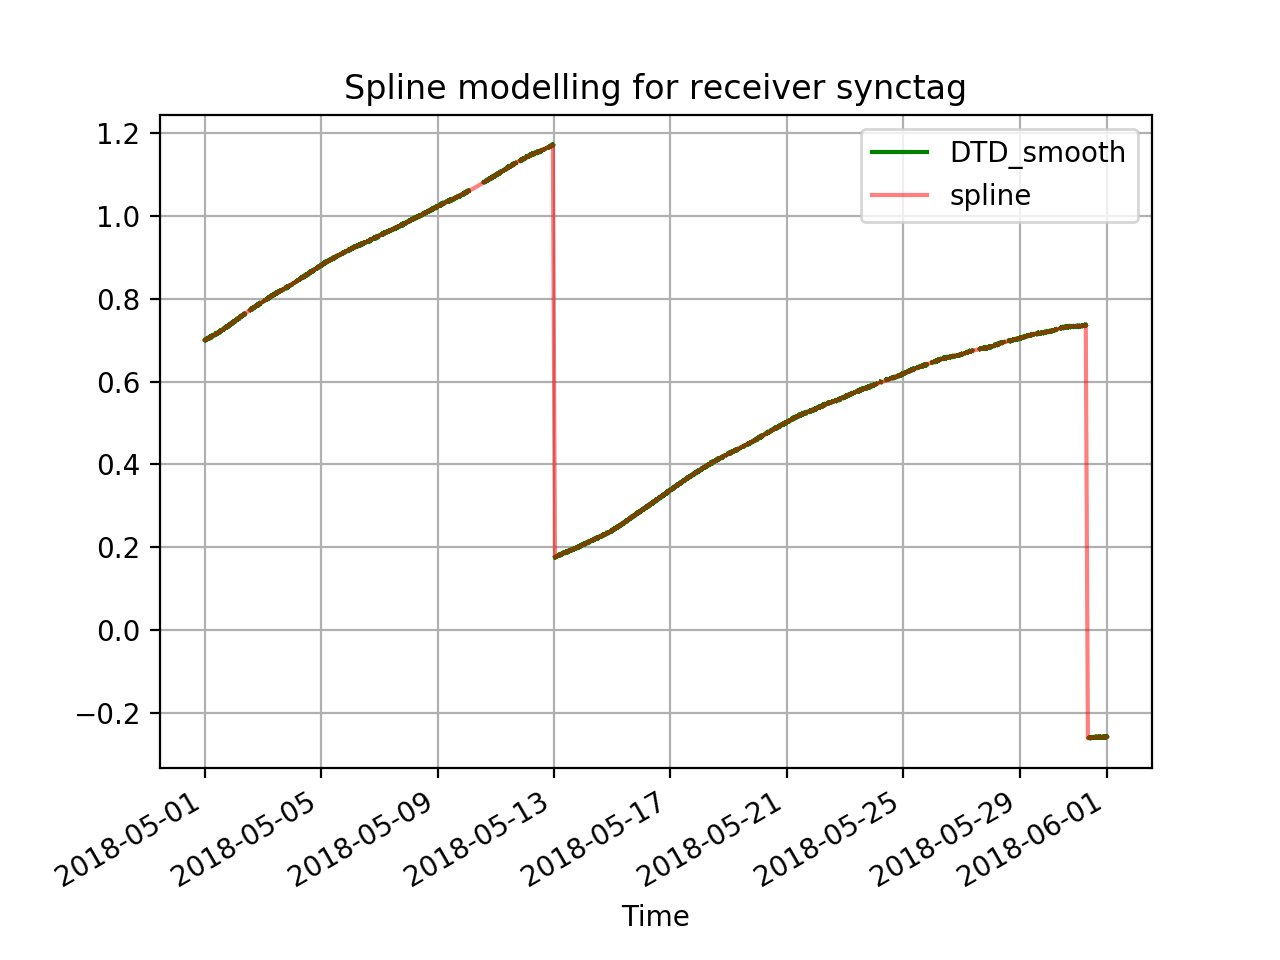

Text(0.5, 1.0, 'Spline modelling for receiver synctag')

In [12]:
fig,ax = plt.subplots()
Srec_on_rec.plot(x='Time', y='DTD_smooth', ax=ax, c='green', grid=True, label='DTD_smooth')
ys_Srec.plot(x='Time', y='spline_Srec', ax=ax, c='red', grid=True, alpha=0.5, label='spline')
ax.set_title('Spline modelling for receiver synctag')

# DTD and spline of base_receiver synctag

In [13]:
Sbase_on_rec = pd.read_pickle('461211_Sbase.pkl')

<IPython.core.display.Javascript object>


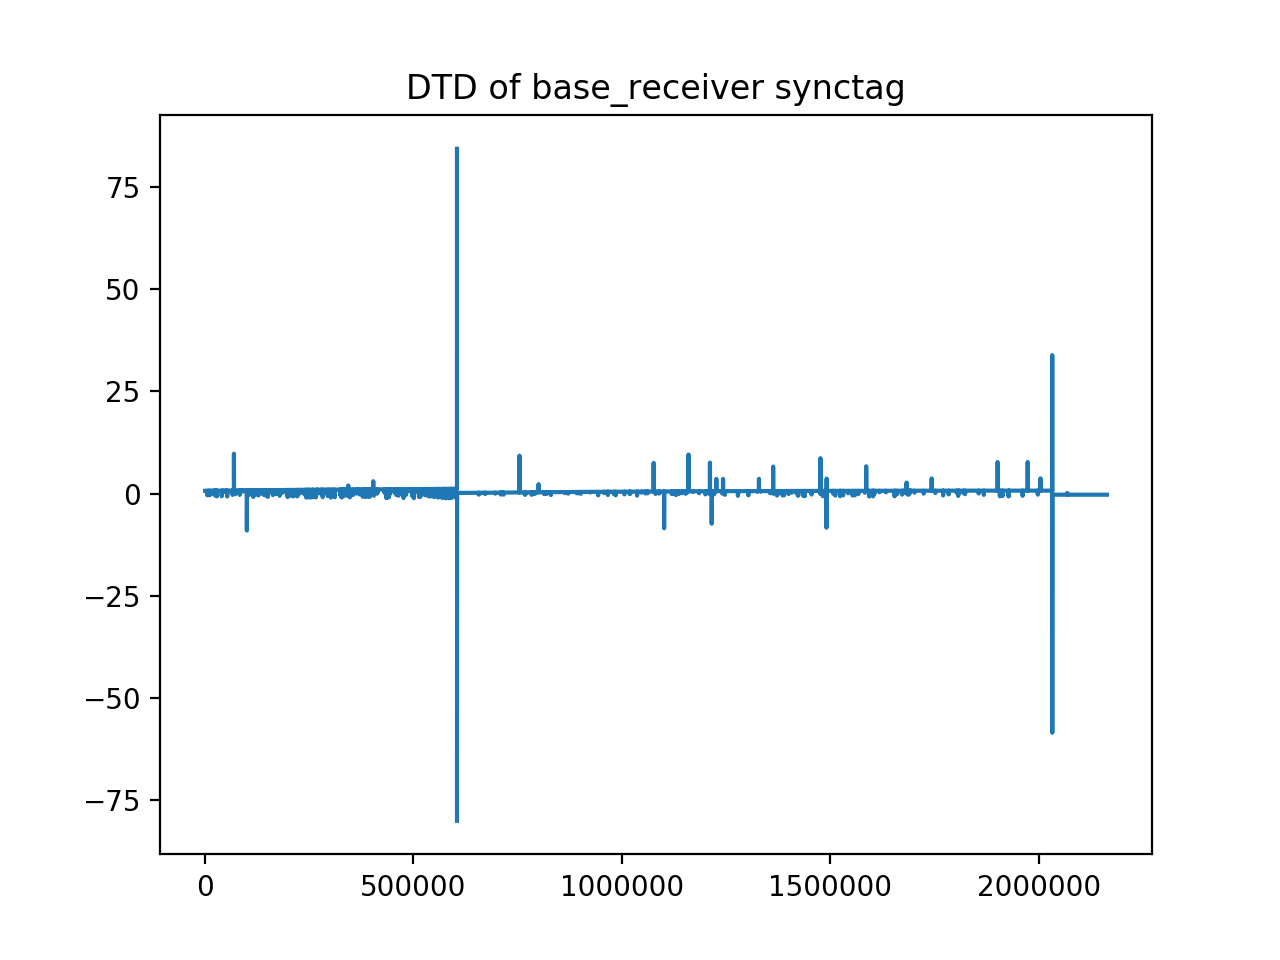

Text(0.5, 1.0, 'DTD of base_receiver synctag')

In [14]:
fig,ax = plt.subplots()
Sbase_on_rec.DTD.plot(ax=ax)
ax.set_title('DTD of base_receiver synctag')


In [15]:
Sbase_on_rec = smooth_DTD(Sbase_on_rec, outlier_lim=0.001, window_size=6)
# If the DTD is already smooth enough, uncomment line below and comment line above:
#Sbase_on_rec['DTD_smooth'] = Sbase_on_rec['DTD']

<IPython.core.display.Javascript object>


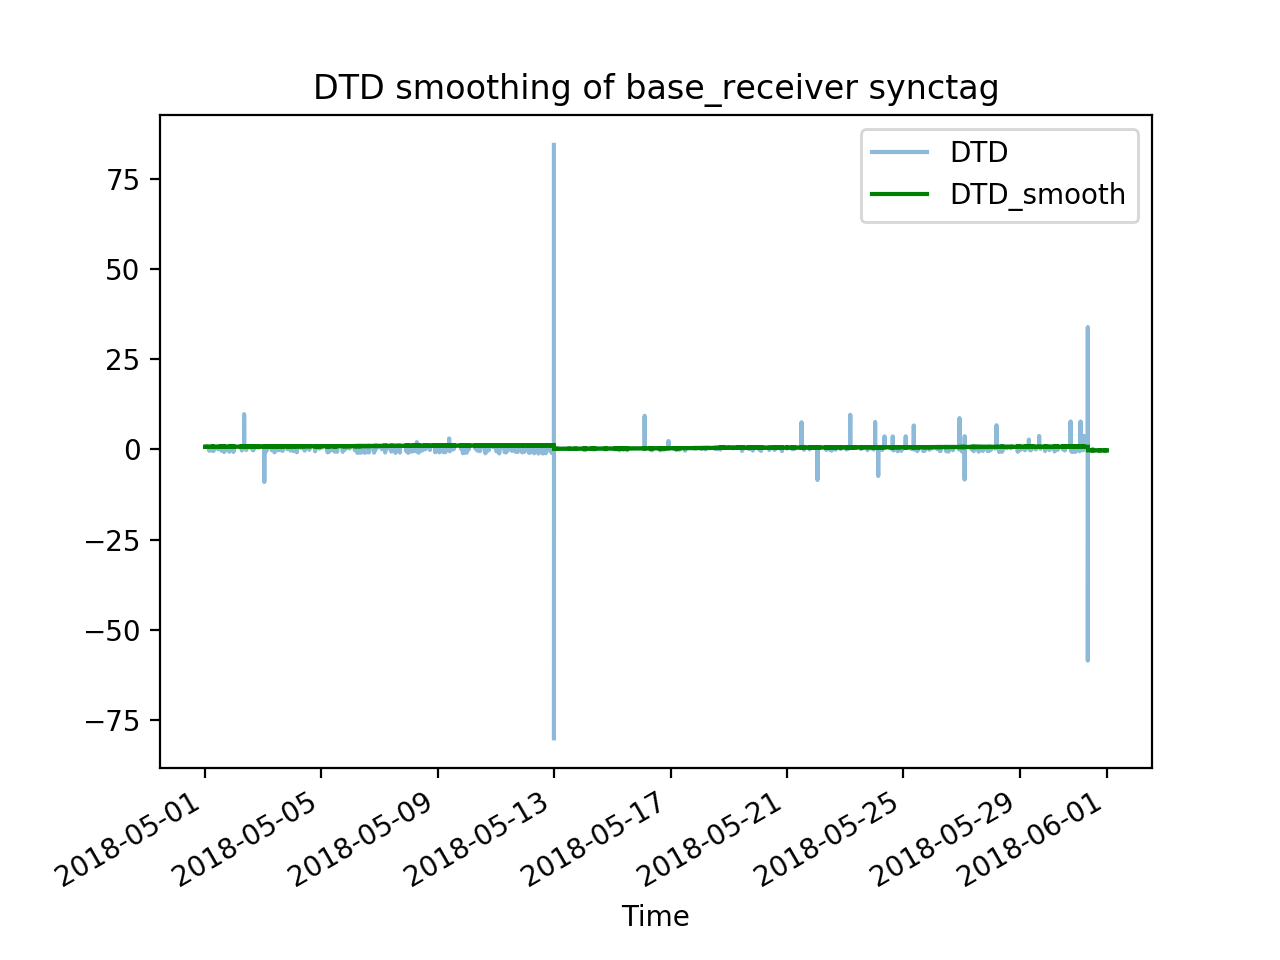

Text(0.5, 1.0, 'DTD smoothing of base_receiver synctag')

In [16]:
fig,ax = plt.subplots()
Sbase_on_rec.plot(x='Time',y='DTD', ax=ax, alpha=0.5, label='DTD')
Sbase_on_rec.plot(x='Time',y='DTD_smooth',  ax=ax, c='green', label='DTD_smooth')
ax.set_title('DTD smoothing of base_receiver synctag')

**Split the dataframe in groups at the jumps.**


In [17]:
DTD_part_Sbase = Sbase_on_rec[['Time', 'DTD_smooth']].set_index('Time')
DTD_part_Sbase = DTD_part_Sbase.dropna()
gaps = DTD_part_Sbase.DTD_smooth.diff().abs()>0.1
groups = gaps.cumsum()
df_grouped = DTD_part_Sbase.groupby(groups)

**Model the spline of each group**

In [18]:
spline_groups = df_grouped.apply(lambda x: model_spline_part(x, ts, k=5, s=5e-4))
ys_Sbase = spline_groups.reset_index()
ys_Sbase.rename(columns={'spline':'spline_Sbase'}, inplace=True)

<IPython.core.display.Javascript object>


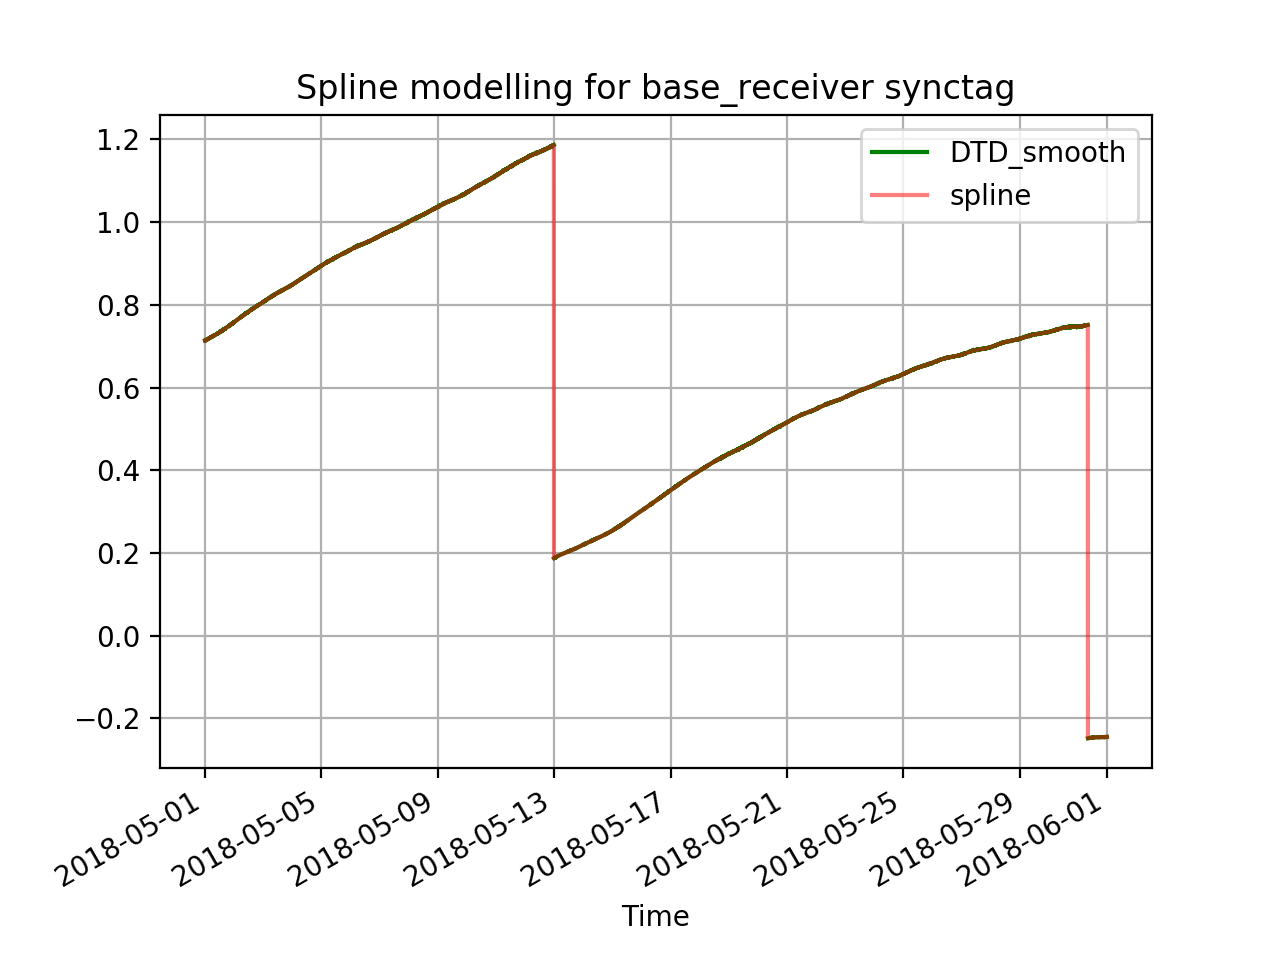

Text(0.5, 1.0, 'Spline modelling for base_receiver synctag')

In [19]:
fig,ax = plt.subplots()
Sbase_on_rec.plot(x='Time', y='DTD_smooth', ax=ax, c='green', grid=True, label='DTD_smooth')
ys_Sbase.plot(x='Time', y='spline_Sbase', ax=ax, c='red', grid=True, alpha=0.5, label='spline')
ax.set_title('Spline modelling for base_receiver synctag')


# Resulting spline

In [20]:
receiver_complete = pd.merge(receiver_complete, ys_Srec[['Time', 'spline_Srec']], on='Time', how='left')
receiver_complete = pd.merge(receiver_complete, ys_Sbase[['Time', 'spline_Sbase']], on='Time', how='left')

In [21]:
receiver_complete['spline'] = (receiver_complete.spline_Srec+receiver_complete.spline_Sbase)/2

<IPython.core.display.Javascript object>


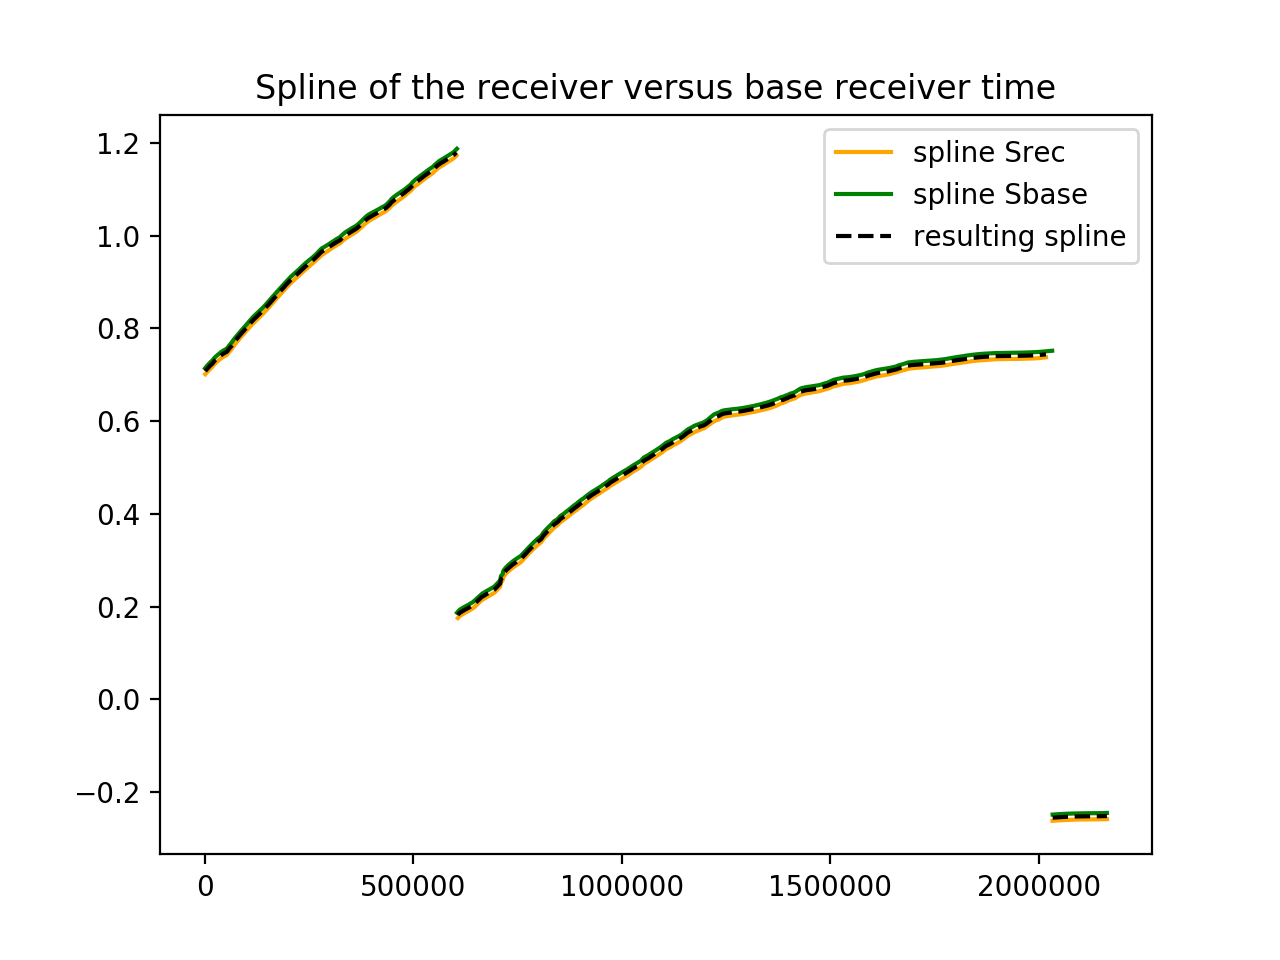

Text(0.5, 1.0, 'Spline of the receiver versus base receiver time')

In [22]:
fig,ax = plt.subplots()
receiver_complete.spline_Srec.plot(ax=ax, c='orange', legend='spline Srec', label='spline Srec')
receiver_complete.spline_Sbase.plot(ax=ax, c='green', legend='spline Sbase', label='spline Sbase')
receiver_complete.spline.plot(ax=ax, c='black', linestyle='--', legend='resulting spline', label='resulting spline')
ax.set_title('Spline of the receiver versus base receiver time')


In [ ]:
receiver_complete['synced_time'] = receiver_complete.Time - receiver_complete.spline.apply(lambda x: pd.Timedelta(x, unit='s'))

In [ ]:
receiver_complete.to_pickle('461211_synced.pkl')

# Check DTD after synchronisation

After synchronisation, the DTDs should be centered around zero   
Check this by running the code below (takes some minutes!)

In [ ]:
Sbase_ID = '62059'
Srec_ID = '62211'

receiver_base = pd.read_pickle('example_base_461059.pkl')
receiver_base.rename(columns={'Time':'synced_time'}, inplace=True)

In [ ]:
Sbase_on_base = receiver_base[receiver_base.ID==Sbase_ID].copy()
Sbase_on_rec = receiver_complete[receiver_complete.ID==Sbase_ID].copy()
Srec_on_base = receiver_base[receiver_base.ID==Srec_ID].copy()
Srec_on_rec = receiver_complete[receiver_complete.ID==Srec_ID].copy()

In [ ]:
from Time_sync_functions import get_DTD, add_DTD

In [ ]:
Sbase_on_rec = add_DTD(Sbase_on_rec, Sbase_on_base, tcol='synced_time', time_margin=100)
Srec_on_rec = add_DTD(Srec_on_rec, Srec_on_base, tcol='synced_time', time_margin=100)

In [ ]:
Sbase_on_rec = smooth_DTD(Sbase_on_rec, outlier_lim=0.001, window_size=6)
Srec_on_rec = smooth_DTD(Srec_on_rec, outlier_lim=0.001, window_size=6)


In [ ]:
fig,ax = plt.subplots()
Srec_on_rec.DTD_smooth.plot(ax=ax, c='orange')
Sbase_on_rec.DTD_smooth.plot(ax=ax, c='green')
